# budget
> Return the total budget for a given calculation period

In [ ]:
#| default_exp budget

Importing all of the required libraries:

In [ ]:
#| export
from sys import exit
from datetime import date, timedelta
from array import array
from ast import literal_eval
from fastcore.script import *

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

The entry point of the `budget` console script:

In [ ]:
#| export
@call_parse
def main(budget:float,        # The budget amount per day
         start_date:str,      # The start date of the calculation period; it is expected to be in the ISO 8601 format
         end_date:str,        # The end date of the calculation period; it is expected to be in the ISO 8601 format
         days_in_week:int=6,  # The number of consecutive days in a week (starting from Monday) to include in the budget
         weights:str=None,    # The weight to apply for each day of a week, and specified as '[x0, .. , xn]', where x0..xn are numbers; this will override --days_in_week
         amounts:str=None):   # The budget amount for each day of a week, and specified as '[x0, .. , xn]', where x0..xn are numbers; the budget amount per day that was specified will be ignored
    """Return the total budget for the calculation period from the start date to the end date (inclusive)."""
    total_budget = 0.0
    try:
        start = date.fromisoformat(start_date)
    except ValueError:
        exit('budget: error: start_date is not in ISO date format\n')
    try:
        end = date.fromisoformat(end_date)
    except ValueError:
        exit('budget: error: end_date is not in ISO date format\n')
    if end < start:
        exit('budget: error: end_date is not after start_date\n')
    elif end == start:
        total_budget = budget
    else:
        if days_in_week < 1 or days_in_week > 7:
            exit('budget: error: days_in_week must be a value from 1 to 7\n')
        ws = array('d')
        if weights is None:  # use the command-line argument, days_in_week, to create the weights that are applied for calculating the total budget
            for d in range(7):
                if d in range(days_in_week):
                    ws.append(1.0)
                else:
                    ws.append(0.0)
        else:  # use the command-line argument, weights, as the weights to be applied when calculating the total budget
            try:
                ls = literal_eval(weights)
            except:
                exit("budget: error: WEIGHTS should be a string that represents a list of numbers only (each element of the list can be an integer or a real number)\n")
            if len(ls) != 7:
                exit('budget: error: WEIGHTS should be a list with a length of 7 elements (because there are 7 days in a week)\n')
            ws.fromlist(ls)
        amts = array('d')
        if amounts is None:  # use the command-line argument, budget, to create the daily budget amounts for calculating the total budget
            for d in range(7):
                amts.append(budget)
        else:  # use the command-line argument, amounts, as the daily budget amounts to be applied when calculating the total budget
            try:
                ls = literal_eval(amounts)
            except:
                exit("budget: error: AMOUNTS should be a string that represents a list of numbers only (each element of the list can be an integer or a real number)\n")
            if len(ls) != 7:
                exit('budget: error: AMOUNTS should be a list with a length of 7 elements (because there are 7 days in a week)\n')
            amts.fromlist(ls)
        period = end - start
        dates = [start + timedelta(days=i) for i in range(period.days + 1)]
        for dt in dates:
            total_budget += amts[dt.weekday()] * ws[dt.weekday()]
    return total_budget

## Unit Tests

The calendar for the month of August in 2023:

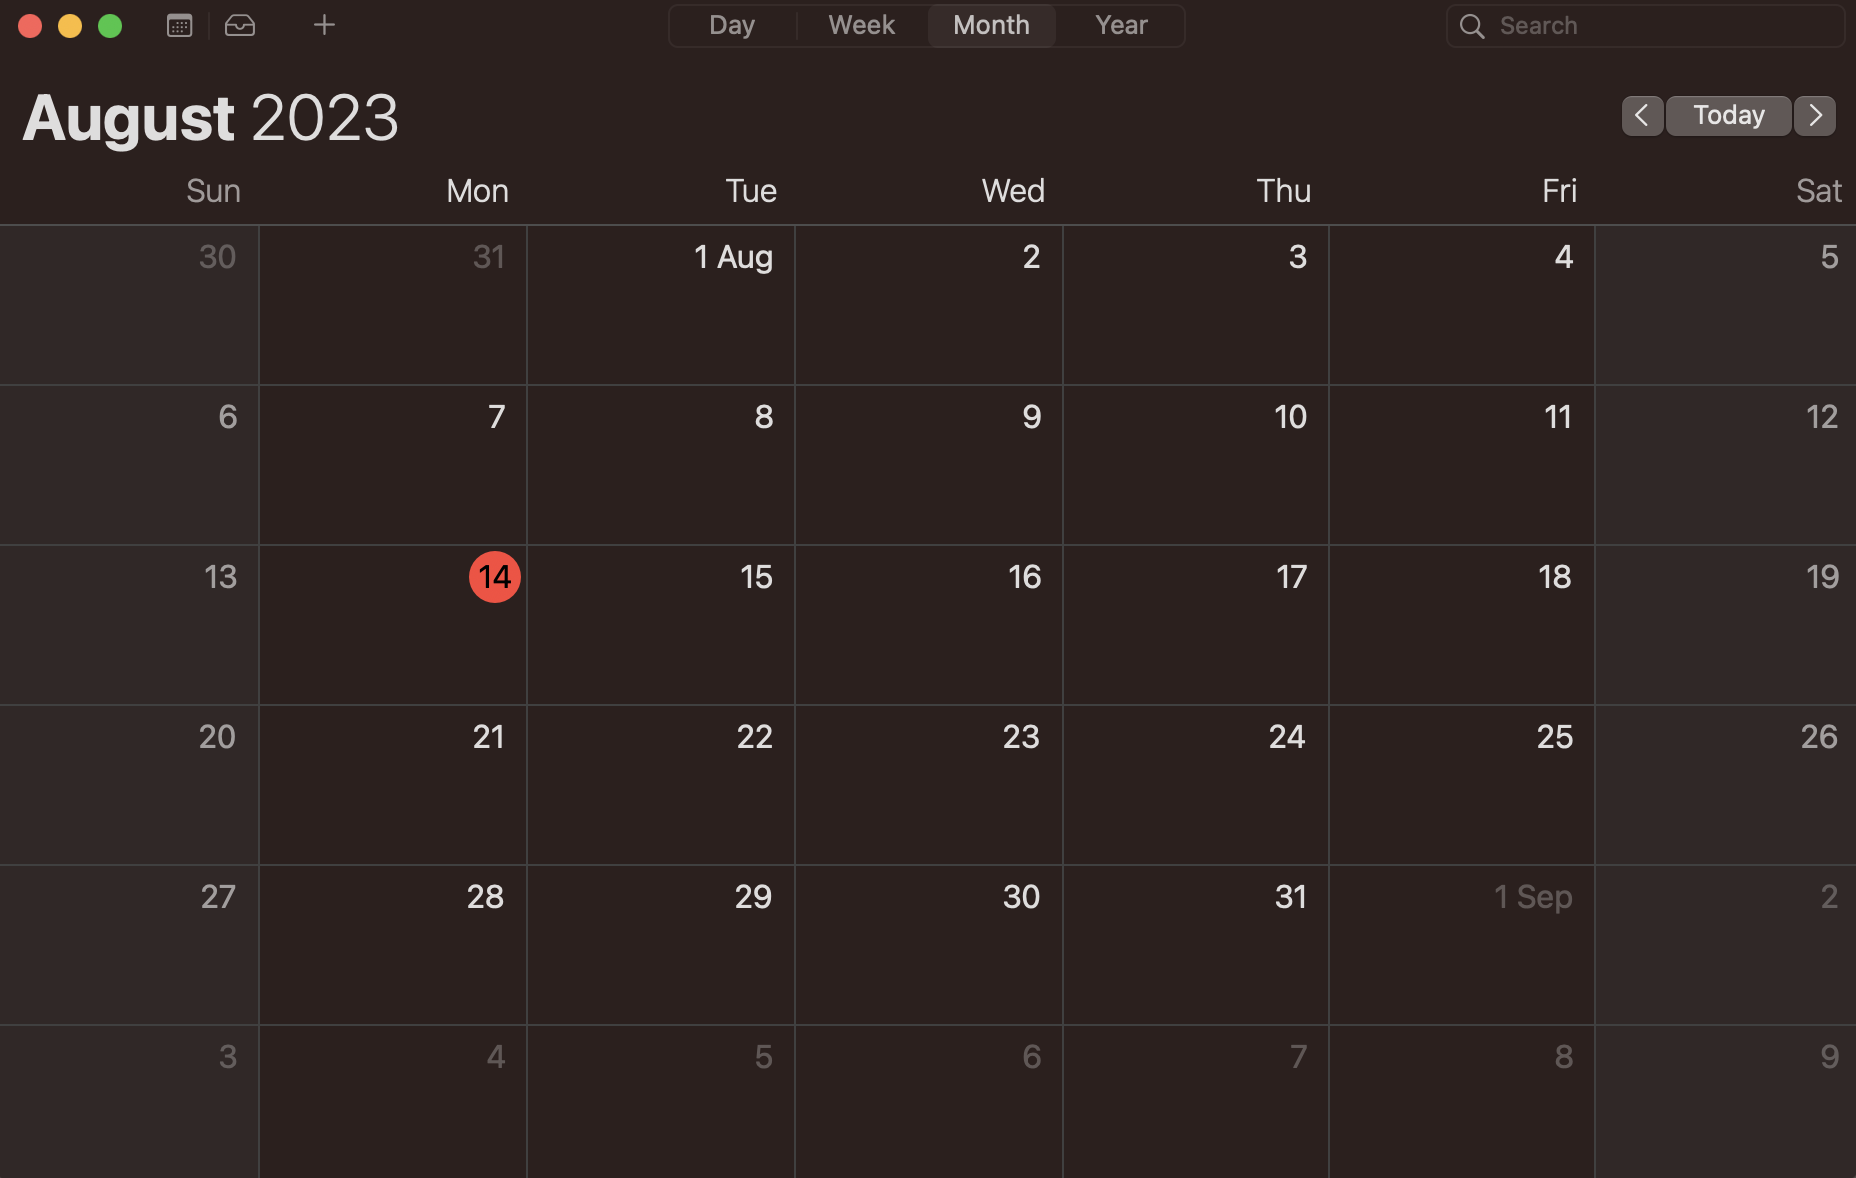

Testing the scenario where the `start_date` and `end_date` are of the expected _ISO 8601_ date format:

In [ ]:
test_eq(main(budget=1, start_date='20230813', end_date='20230902'),
        18.0)

Testing the scenario where the `start_date` and `end_date` are of the expected _ISO 8601_ date format, and the `days_in_week` argument is a different value from the default value of 6:

In [ ]:
test_eq(main(budget=1, start_date='20230813', end_date='20230902', days_in_week=7),
        21.0)

Testing a different variation of the date format that is an accepted variation in the _ISO 8601_ standard:

In [ ]:
test_eq(main(budget=1, start_date='2023-08-13', end_date='2023-09-02'),
        18.0)

Testing a set of `weights` that is equivalent to `days_in_weeks` = 6:

In [ ]:
test_eq(main(budget=1, start_date='20230813', end_date='20230902', weights='[1,1,1,1,1,1,0]'),
        18.0)

Testing a set of `weights` that is equivalent to `days_in_weeks` = 7:

In [ ]:
test_eq(main(budget=1, start_date='20230813', end_date='20230902', weights='[1,1,1,1,1,1,1]'),
        21.0)

Testing a set of `amounts` in conjunction with the default value of `days_in_week` = 6:

In [ ]:
test_eq(main(budget=1, start_date='20230813', end_date='20230902', amounts='[1,1,1,1,1,1,0]'),
        18.0)

Because `days_in_week` = 6, `ws` will take on the value of [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0], and `total_budget` will not take into consideration the 7th element of `amts` (which is also `amounts`):

In [ ]:
test_eq(main(budget=1, start_date='20230813', end_date='20230902', amounts='[1,1,1,1,1,1,1]'),
        18.0)

The following test case will take into consideration the 7th element of `amts` (and `amounts`), as `days_in_week` = 7:

In [ ]:
test_eq(main(budget=1, start_date='20230813', end_date='20230902', amounts='[1,1,1,1,1,1,1]',
             days_in_week=7), 21.0)

`sys.exit()` is invoked when the `start_date` is not of the _ISO 8601_ date format, and it raises a `SystemExit` exception:

In [ ]:
#with ExceptionExpected(ex=SystemExit): main(budget=1, start_date='2023', end_date='20230902')

Similarly, `sys.exit()` is invoked when the `end_date` is not of the _ISO 8601_ date format, and it raises a `SystemExit` exception:

In [ ]:
#with ExceptionExpected(ex=SystemExit): main(budget=1, start_date='20230813', end_date='2023')

The `SystemExit` exception is raised by `sys.exit()` when the `end_date` is before the `start_date`:

In [ ]:
#with ExceptionExpected(ex=SystemExit): main(budget=1, start_date='20230813', end_date='20230808')

The `SystemExit` exception is raised by `sys.exit()` when the `weights` argument is not well-formed:

In [ ]:
#with ExceptionExpected(ex=SystemExit): main(budget=1, start_date='20230813', end_date='20230902', weights='[1,a,1,1,1,1,0]')

The same exception is raised when the `amounts` argument is not well-formed:

In [ ]:
#with ExceptionExpected(ex=SystemExit): main(budget=1, start_date='20230813', end_date='20230902', amounts='[1,a,1,1,1,1,0]')

Also, the `SystemExit` exception is raised when the `weights` argument has less than 7 elements:

In [ ]:
#with ExceptionExpected(ex=SystemExit): main(budget=1, start_date='20230813', end_date='20230902', weights='[1,1,1]')

The same outcome when the `amounts` argument has less than 7 elements:

In [ ]:
#with ExceptionExpected(ex=SystemExit): main(budget=1, start_date='20230813', end_date='20230902', amounts='[1,1,1]')

The same exception is raised when the `days_in_week` argument is not of the integer value from 1 to 7:

In [ ]:
#with ExceptionExpected(ex=SystemExit): main(budget=1, start_date='20230813', end_date='20230902', days_in_week = 8)
#with ExceptionExpected(ex=SystemExit): main(budget=1, start_date='20230813', end_date='20230902', days_in_week = 0)

In [ ]:
#| hide
#import nbdev; nbdev.nbdev_export()